In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

%run ./datos.ipynb
%run ./cuadradosMin.ipynb

## Graficos

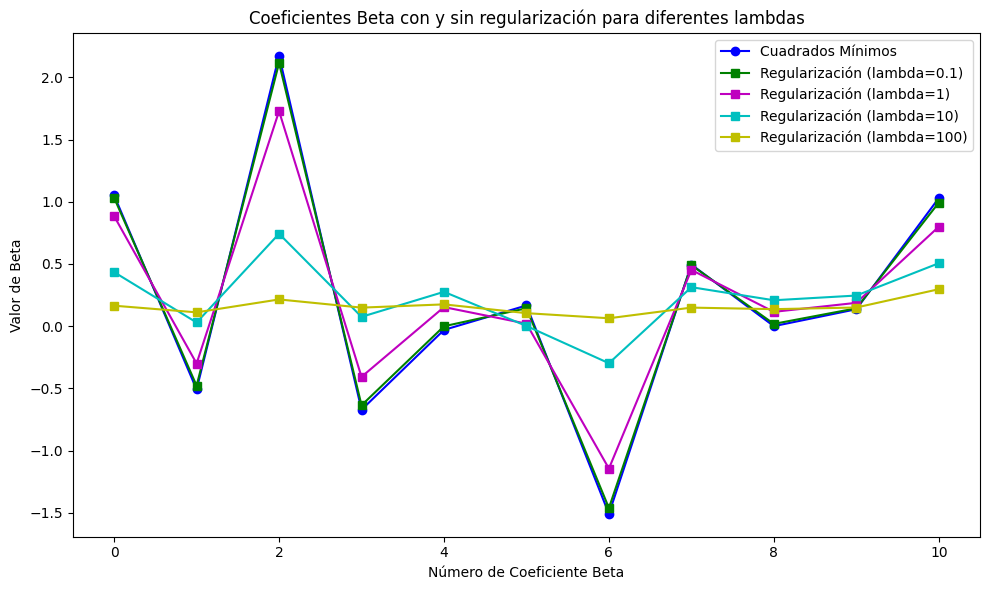

In [2]:
np.random.seed(10)
N = 100
M = 10

# datos independientes
A_actual = np.random.rand(N, M)

# pendiente y ordenada al origen aleatorios
beta = np.random.randn(1,M + 1)

# se agrega una columna de unos
A_actual = np.c_[A_actual, np.ones(N)]

# separamos los datos en ajuste y validación intercalados
A_ajuste_actual = A_actual[::2]
A_val_actual = A_actual[1::2]

# creamos los datos dependientes
y = (beta @ A_actual.T).T + np.random.randn(N, 1) * 0.05

y_ajuste_actual = y[::2]
y_val_actual = y[1::2]

# Valores de lambda a graficar
lambdas = [0.1, 1, 10, 100]

# Graficar coeficientes
plt.figure(figsize=(10, 6))

# Cuadrados mínimos sin regularización
beta_minimos, _ = cuadrados_minimos(A_ajuste_actual, y_ajuste_actual) # type: ignore
plt.plot(range(len(beta_minimos)), beta_minimos, marker='o', linestyle='-', color='b', label='Cuadrados Mínimos')

# Cuadrados mínimos regularizados para diferentes lambdas
colors = ['g', 'm', 'c', 'y']  # Colores para cada línea
labels = ['Regularización (lambda=0.1)', 'Regularización (lambda=1)', 
          'Regularización (lambda=10)', 'Regularización (lambda=100)']  # Etiquetas para la leyenda

for lam, color, label in zip(lambdas, colors, labels):
    beta_minimosReg, _ = cuadrados_min_reg(A_ajuste_actual, lam, y_ajuste_actual) # type: ignore
    plt.plot(range(len(beta_minimosReg)), beta_minimosReg, marker='s', linestyle='-', color=color, label=label)

# Etiquetas y título
plt.xlabel('Número de Coeficiente Beta')
plt.ylabel('Valor de Beta')
plt.title('Coeficientes Beta con y sin regularización para diferentes lambdas')
plt.legend()
plt.tight_layout()
plt.savefig('./imagenes/coef_regulacion_vs_sin.png')
plt.show()


## Experimentación

3. a. Ajustar una combinación lineal de polinomios de Legendre (sin regularización) en los datos de ajuste y predecir los valores de validación. Calcular los errores de ajuste y de validación para todos los grados desde 1 hasta 2 veces la dimensión de los datos. Graficar ambos errores en función del grado en escala logarítmica en y.

In [3]:
# Calcular grado máximo
grado_max = 2 * A_ajuste.shape[0] # type: ignore
ajuste_errores = np.zeros(grado_max)
val_errores = np.zeros(grado_max)

for i in range(1, grado_max + 1):
    # Ajustamos matriz de ajuste
    A_legendre = np.polynomial.legendre.legvander(A_ajuste, i) # type: ignore
    beta_actual, y_pred = cuadrados_minimos(A_legendre, y_ajuste) # type: ignore
    
    # calculamos error de ajuste
    ajuste_errores[i - 1] = ECM(beta_actual, A_legendre, y_ajuste) # type: ignore
    
    # calculamos error de validación
    A_legendre_val = np.polynomial.legendre.legvander(A_val, i) # type: ignore
    val_errores[i - 1] = ECM(beta_actual, A_legendre_val, y_val) # type: ignore
    

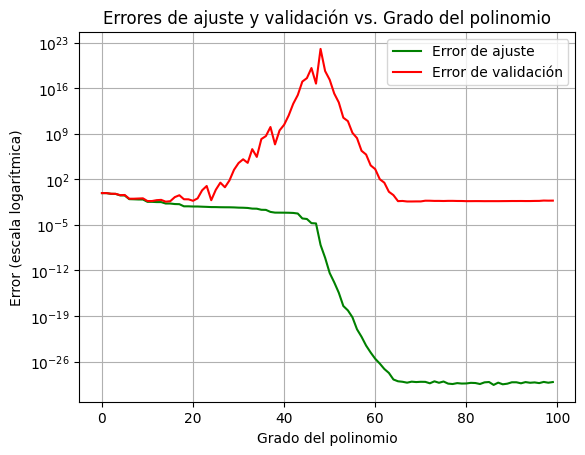

mínimo error de validación: 0.03745596723389653
grado con el mínimo error de validación: 14


In [19]:
plt.plot(range(0, grado_max), ajuste_errores, label='Error de ajuste', color='green')
plt.plot(range(0, grado_max), val_errores, label='Error de validación', color='red')
plt.yscale('log')
plt.xlabel('Grado del polinomio')
plt.ylabel('Error (escala logarítmica)')
plt.title('Errores de ajuste y validación vs. Grado del polinomio')
plt.legend()
plt.grid(True)
plt.savefig('./imagenes/error_ajuste_vs_validacion.png')
plt.show()

print("mínimo error de validación:", (min(val_errores)))
print("grado con el mínimo error de validación:", (np.argmin(val_errores)))


3. b. Explorar los hiperparámetros grado del polinomio y valor de regularización λ. Reportar el grado y λ que minimiza el
error en los datos de validación.

In [5]:
def minimizar_lam_grado(rango_grados, rango_lam):
    min_grado = 0
    min_lamb = 0
    min_ecm = 1e6

    resultados = np.zeros((len(rango_grados), len(rango_lam)))

    for i in range(len(rango_grados)):
        for j in range(len(rango_lam)):
            grado_actual = rango_grados[i]
            lam_actual = rango_lam[j]

            A_legendre = np.polynomial.legendre.legvander(A_ajuste, grado_actual) # type: ignore
            beta_actual, y_actual = cuadrados_min_reg(A_legendre, lam_actual, y_ajuste) # type: ignore

            A_legendre_val = np.polynomial.legendre.legvander(A_val, grado_actual) # type: ignore
            ecm_actual = ECM(beta_actual, A_legendre_val, y_val) # type: ignore

            if (ecm_actual < min_ecm): # type: ignore
                min_grado = grado_actual
                min_lamb = lam_actual
                min_ecm = ecm_actual
            
            resultados[i][j] = ecm_actual
    return resultados, min_grado, min_lamb, min_ecm

In [6]:
rango_grados = np.arange(1, 80)

rango_lambdas = np.linspace(0, 1, 100) 

resultados, min_grado, min_lamb, min_ecm = minimizar_lam_grado(rango_grados, rango_lambdas)

Minimo ECM de validacion:  0.013056795323871929
lambda:  0.020202020202020204
grado:  32


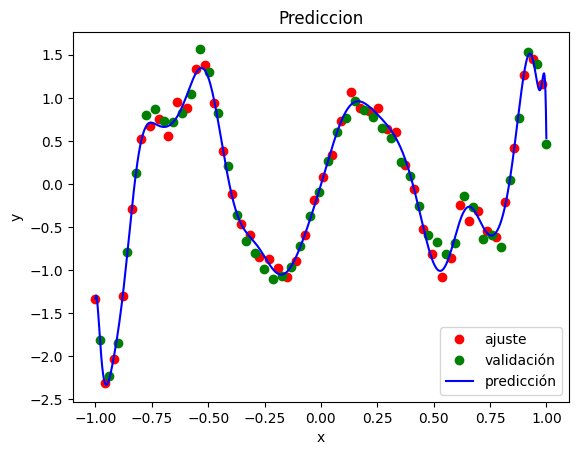

In [7]:
A_legendre_pred = np.polynomial.legendre.legvander(A_ajuste, min_grado) # type: ignore
beta_pred, y_pred = cuadrados_min_reg(A_legendre_pred, min_lamb, y_ajuste)  # type: ignore

print('Minimo ECM de validacion: ', min_ecm)
print('lambda: ', min_lamb)
print('grado: ', min_grado)

curva_x = np.linspace(-1, 1, 1000) # crear un conjunto de puntos finamente espaciados en el rango de valores de entrada, para representar visualmente una curva de ajuste más suave y continua
y_pred_curva = predecir(beta_pred, curva_x, min_grado) # type: ignore

plt.plot(A_ajuste,y_ajuste,'o', color='red', label='ajuste') # type: ignore
plt.plot(A_val,y_val,'o', color='green', label='validación') # type: ignore
plt.plot(curva_x, y_pred_curva,'-', color='blue', label='predicción') # type: ignore
plt.title('Prediccion')
plt.xlabel('x')
plt.ylabel('y')

plt.legend()
plt.savefig('./imagenes/prediccion.png')
plt.show()

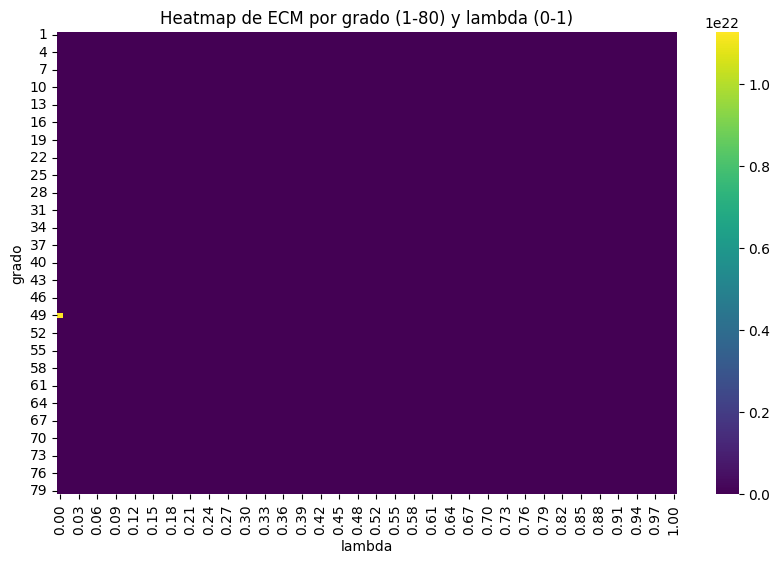

In [8]:
df = pd.DataFrame(data=resultados, index=rango_grados, columns=['%.2f' % lamb for lamb in rango_lambdas])
plt.figure(figsize=(10, 6))
ax = sns.heatmap(df, cmap='viridis')
ax.set(xlabel = "lambda", ylabel = "grado")
plt.title('Heatmap de ECM por grado (1-80) y lambda (0-1)')
plt.savefig('./imagenes/heatmap.png')
plt.show()

Por los resultados de la anterior celda, acotamos el rango de los grados y lambdas para ver mejor los resultados

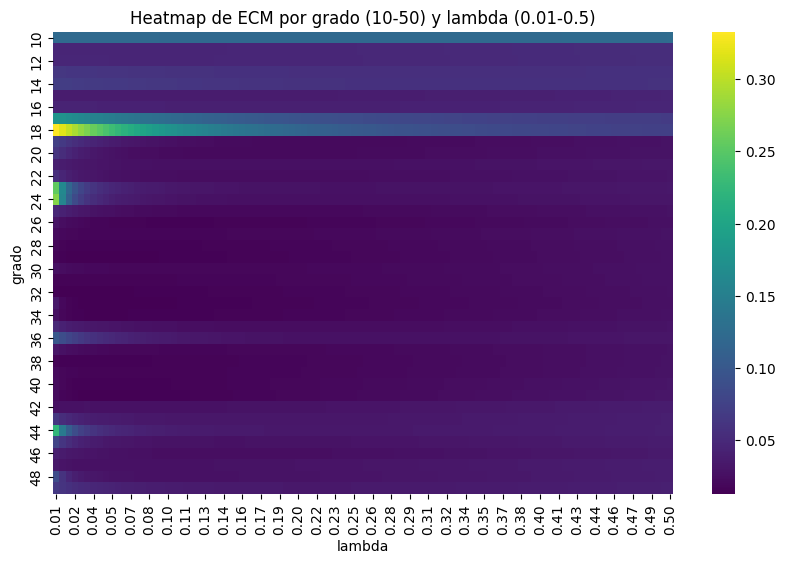

In [9]:
rango_grados_acotado = np.arange(10,50)
rango_lambdas_acotado = np.linspace(0.01, 0.5, 100)

resultados_acotado, min_grado_acotado, min_lamb_acotado, _ = minimizar_lam_grado(rango_grados_acotado, rango_lambdas_acotado)

df = pd.DataFrame(data=resultados_acotado, index=rango_grados_acotado, columns=['%.2f' % lamb for lamb in rango_lambdas_acotado])
plt.figure(figsize=(10, 6))
ax = sns.heatmap(df, cmap='viridis')
ax.set(xlabel = "lambda", ylabel = "grado")
plt.title('Heatmap de ECM por grado (10-50) y lambda (0.01-0.5)')
plt.savefig('./imagenes/heatmap-primer-corte.png')
plt.show()

Vemos que en los grados 27-34 se ve con menor error entonces acotamos otra vez

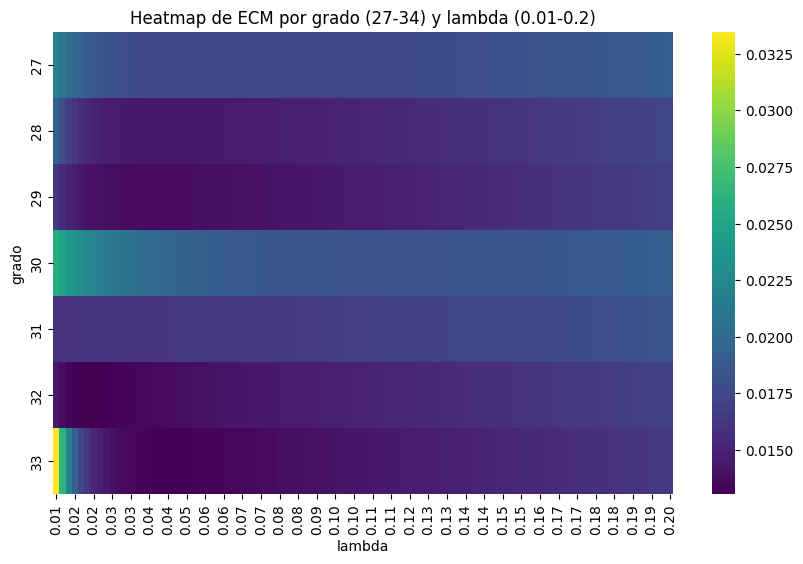

In [10]:
rango_grados_acotado2 = np.arange(27,34)
rango_lambdas_acotado2 = np.linspace(0.01, 0.2, 100)

resultados_acotado2, min_grado_acotado2, min_lamb_acotado2, _ = minimizar_lam_grado(rango_grados_acotado2, rango_lambdas_acotado2)

df = pd.DataFrame(data=resultados_acotado2, index=rango_grados_acotado2, columns=['%.2f' % lamb for lamb in rango_lambdas_acotado2])
plt.figure(figsize=(10, 6))
ax = sns.heatmap(df, cmap='viridis')
ax.set(xlabel = "lambda", ylabel = "grado")
plt.title('Heatmap de ECM por grado (27-34) y lambda (0.01-0.2)')
plt.savefig('./imagenes/heatmap-segundo-corte.png')
plt.show()

Seteamos el valor máximo como la media de los errores así nos deshacemos de los valores mayores y vemos mejor los valores menores que son los que nos interesan


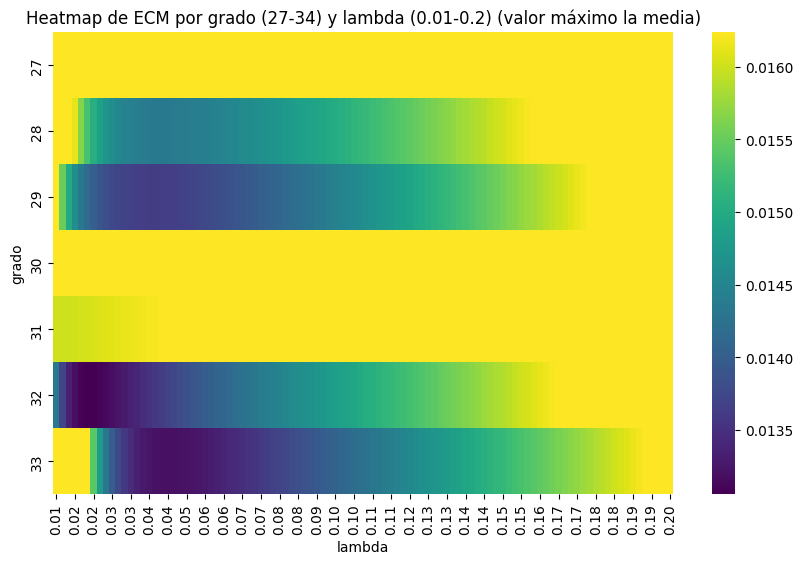

True
0.01318411302716714


In [11]:
rango_grados_acotado2 = np.arange(27,34)
rango_lambdas_acotado2 = np.linspace(0.01, 0.2, 100)

resultados_acotado2, min_grado_acotado2, min_lamb_acotado2, _ = minimizar_lam_grado(rango_grados_acotado2, rango_lambdas_acotado2)

df = pd.DataFrame(data=resultados_acotado2, index=rango_grados_acotado2, columns=['%.2f' % lamb for lamb in rango_lambdas_acotado2])
plt.figure(figsize=(10, 6))
ax = sns.heatmap(df, cmap='viridis', vmax=np.median(resultados_acotado2))
ax.set(xlabel = "lambda", ylabel = "grado")
plt.title('Heatmap de ECM por grado (27-34) y lambda (0.01-0.2) (valor máximo la media)')
plt.savefig('./imagenes/heatmap-segundo-corte-con-valor-medio.png')
plt.show()

print(min(resultados_acotado2[5]) < min(resultados_acotado2[6]))
print(min(resultados_acotado2[6]))